# Select dispatching rules by predicting profit with neural networks

This notebook presents an implementation of a neural network to predict the success of different dispatching rules. This prediction can then be used to select the best performing rule.

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import sys
import pandas as pd
import seaborn as sns
import pickle
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from joblib import dump, load
from datetime import datetime
from time import mktime
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src.models import train_pipeline_model, evaluate_pipeline,  optimize_hyperparameters, plot_learning_curve
from src.utils import get_hyperparameter_number
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt, \
    assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, run_simulation_complete

## Get required data

In [2]:
# Load the training data
with open(r"../data/processed/data_processed_regression_training.pickle", "rb") as output_file:
    data_train = pickle.load(output_file)

In [3]:
# Load the validation data
with open(r"../data/processed/data_processed_regression_validation.pickle", "rb") as output_file:
    data_validation = pickle.load(output_file)

In [4]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [5]:
# Define constants for model training
RANDOM_STATE = 42
numeric_features = list(data_train.columns)
numeric_features.remove("priority_rule_start")
numeric_features.remove("priority_rule_score")
numeric_features.remove("profit")
categorical_features =  ["priority_rule_start", "priority_rule_score"]

In [6]:
# Define constants for simulation
priority_rules = {"edd": assign_priority_edd,
                  "spt": assign_priority_spt,
                  "srpt": assign_priority_srpt,
                  "fifo": assign_priority_fifo,
                  "cr": assign_priority_cr,
                  "mdd": assign_priority_mdd,
                  "lpt": assign_priority_lpt,
                  "ds": assign_priority_ds}
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list =  [40, 50, 60, 70]
random_states = [100, 101, 102]

# Prepare data

In [7]:
# Define features and flag
X = data_train.drop("profit",  axis = 1)
y = data_train[["profit"]]
X_validate = data_validation.drop("profit",  axis = 1)
y_validate = data_validation[["profit"]]

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model training

## Baseline

In [9]:
# Simple dummy regressor based on the mean
dummy = DummyRegressor(strategy="mean")
dummy_fit = dummy.fit(X_train, y_train)
print(f"R2 of the dummy regressor is: {round(dummy_fit.score(X_test, y_test), 4)}")

R2 of the dummy regressor is: -0.0


In [10]:
# Simple logistic regression baseline without hyperparameter tuning and feature selection
lr = LinearRegression()
pipeline_lr = train_pipeline_model(lr, X_train, y_train, numeric_features, categorical_features)
evaluate_pipeline(pipeline_lr, X_test, y_test, classification = False)

Start at 10:28:52
Duration: 2.770048141479492
Start at 10:28:55
RMSE: 554497785.7146
R^2: -14251968878.7836
Duration: 0.16576004028320312


## Hyperparameter search

In [11]:
# Define set of hyperparameters
params_mlp = {"classifier__activation": ["identity", "logistic", "tanh", "relu"],
             "classifier__solver": ["lbfgs", "adam"],
             "classifier__alpha": [0.0001, 0.05],
             "classifier__max_iter": [1000, 2000, 5000, 10000],
             "classifier__early_stopping": [True, False],
             "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
             "classifier__hidden_layer_sizes": [(20), (20, 20), (20, 20, 20), (50), (50,20), (50,50), (100)]
            }
print(f"Set of {get_hyperparameter_number(params_mlp)} hyperparameters")

Set of 2688 hyperparameters


Based on the variables we executed a grid hyperparameter search using successful halving.

In [12]:
# Fit hyperparameter search
model = MLPRegressor(random_state = RANDOM_STATE)
feature_selector = None
# fitted_clf = optimize_hyperparameters(X_train, y_train, model, feature_selector,numeric_features, categorical_features, params_mlp, RANDOM_STATE, scoring = "neg_root_mean_squared_error")
# print(fitted_clf.best_params_)
# pd.DataFrame(fitted_clf.cv_results_).to_csv("../data/processed/results_hyperparameter_artificial_neural_network_regression.csv", index = False)

The grid search was executed on a random subset and took 2798.27 seconds. The results are saved in a dataframe and can be read in as a csv file.

In [13]:
# Load hyperparameter results
results_hyperparameter = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_neural_network_regression.csv")

The resulting set of optimal hyperparameter were:
**Neural Network**
* solver="adam"
* max_iter=5000
* learning_rate="adaptive"
* hidden_layer_sizes=(20, 20, 20)
* early_stopping=False
* alpha=0.05
* activation="relu"

## Train final model

Train model for evaluation based on the select hyperparameter.

In [14]:
# Train pipeline based on hyperparameter
# Duration ~30 minutes
final_model = MLPRegressor(random_state=RANDOM_STATE, solver="adam", max_iter=5000, learning_rate="adaptive", hidden_layer_sizes=(20, 20, 20), early_stopping=False, alpha=0.05, activation="relu")
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)

In [15]:
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_regression_neural_network_training.joblib')

In [16]:
# Load trained model
pipeline_trained = load('../models/pipeline_dispatching_regression_neural_network_training.joblib')

## Model evaluation

In [17]:
# Evaluate pipeline on train
evaluate_pipeline(pipeline_trained, X_train, y_train, classification = False)

Start at 10:28:56
RMSE: 1210.6076
R^2: 0.9317
Duration: 1.1929080486297607


In [18]:
# Evaluate pipeline on test
evaluate_pipeline(pipeline_trained, X_test, y_test, classification = False)

Start at 10:28:57
RMSE: 1214.4466
R^2: 0.9316
Duration: 0.3848557472229004


There is no significant difference in the performance of train and test which shows a good learning capability of the model.

In [19]:
# Plot learning curve based on data samples and fitting time
# May take some seconds to calculate
# plot_learning_curve(
#        pipeline_trained,
#        "Evaluation training set neural network regression",
#        X,
#        y.values.ravel(),
#        axes=None,
#        ylim=None,
#        cv=None,
#        n_jobs=-1,
#        scoring="neg_root_mean_squared_error",
#        train_sizes=np.linspace(0.1, 1.0, 5))

We can see that with increasing data samples the gap between training and test is closing very fast. At the end the performance is stagnating so that more data would not necessarily increase the performance anymore.

In [20]:
# Create explainer for the final model
X_validate_processed = pipeline_trained["preprocessor"].transform(X_validate)
shap_sample = shap.sample(X_validate_processed, 1000)

In [21]:
# Create explainer for the final model
# Takes long time for the calculation of the shap values
# explainer = shap.KernelExplainer(pipeline_trained["classifier"].predict_proba, shap_sample)
# shap.initjs()

In [22]:
# Preprocess data to calculate shap values
# shap_values = explainer.shap_values(shap_sample)

In [23]:
# Create a summary plot of the impact
# feature_names = pipeline_trained["preprocessor"].get_feature_names_out(X_validate.columns)
# shap.summary_plot(shap_values, shap_sample, feature_names = feature_names)

## Train full model

In [24]:
# Create combined dataset for training the final model
X_complete = pd.concat([X, X_validate])
y_complete = pd.concat([y, y_validate])

In [25]:
# Train pipeline based on hyperparameter
# Duration ~30 minutes
final_model = MLPRegressor(random_state=RANDOM_STATE, solver="adam", max_iter=5000, learning_rate="adaptive",  hidden_layer_sizes=(20, 20, 20), early_stopping=False, alpha=0.05, activation="relu")
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_regression_neural_network_complete.joblib')

In [26]:
# Load trained model
pipeline_simulation = load('../models/pipeline_dispatching_regression_neural_network_complete.joblib')

# Evaluation in simulation environment

In this section we define a simulation testing environment for testing and comparing the performance of different approaches. For this we create use repeated simulation of a factory with varying experiment settings. The trained algorithm are then used in the process to select dispatching rules.

In [27]:
# Execute simulation
# Duration ~11 minutes
# simulation_results = run_simulation_complete(pipeline_simulation, priority_rules, random_states, due_date_range_list,
#                                             number_orders_start_list,
#                                             average_count_new_orders_list, worker_list, "Neural Network regression",
#                                             product_types_df, machines_df, orders_df, SIMULATION_START, False)

In [28]:
# Save simulation results
# simulation_results.to_csv("../data/processed/simulation_results_validation_regression_neural_network.csv", index = False)

In [29]:
# Load simulation results
simulation_results = pd.read_csv("../data/processed/evaluation/simulation_results_validation_regression_neural_network.csv")

In [30]:
# Analyse simulation results profit
simulation_results["profit"] = simulation_results["revenue"] - simulation_results["penalty"]
print(f"Average profit is: {simulation_results.profit.mean()}")

Average profit is: 7407.710448449824


<AxesSubplot: xlabel='day', ylabel='profit'>

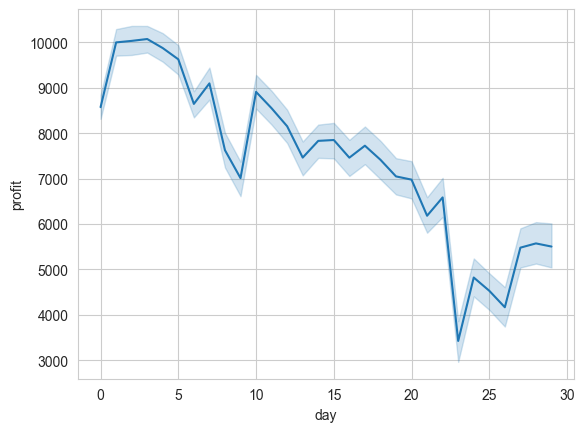

In [31]:
# Visualize profit
sns.lineplot(simulation_results, x = "day", y = "profit")

<AxesSubplot: xlabel='day', ylabel='profit'>

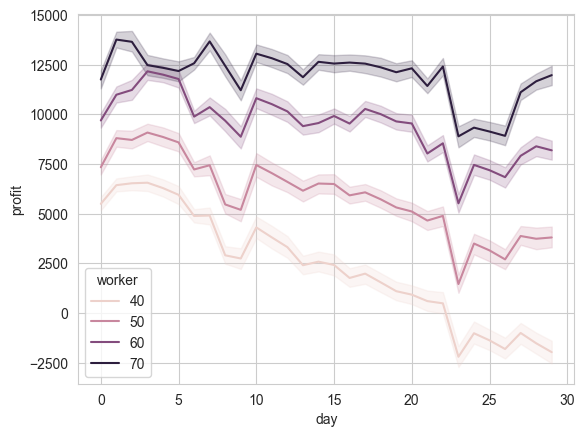

In [32]:
# Visualize profit per worker constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "worker")

<AxesSubplot: xlabel='day', ylabel='profit'>

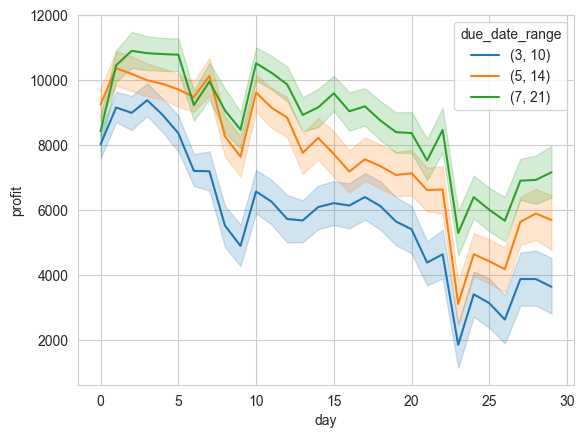

In [33]:
# Visualize profit per due date constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "due_date_range")

<AxesSubplot: xlabel='day', ylabel='profit'>

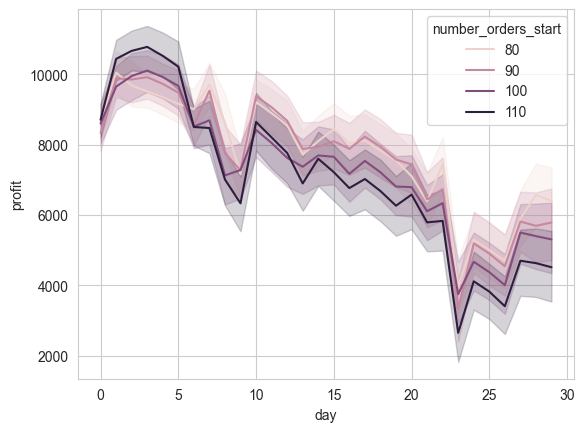

In [34]:
# Visualize profit per number_orders_start constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "number_orders_start")

<AxesSubplot: xlabel='day', ylabel='profit'>

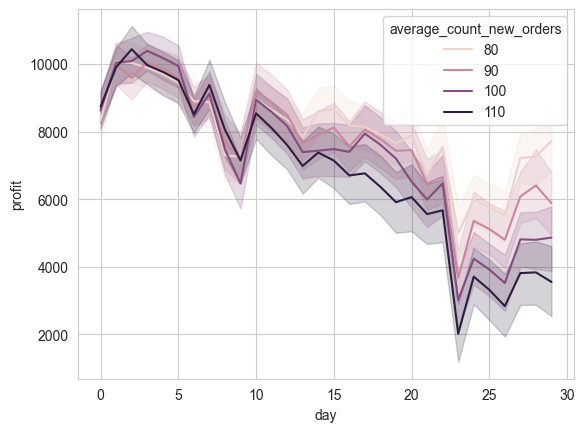

In [35]:
# Visualize profit per average count new orders constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "average_count_new_orders")